---
title: Auxilliary Networks
subtitle: Empowering Injective Networks
date: 2025-02-27
---

We now introduce, **_Auxilliary Networks_**, additions to the basic Injective Network architecture
that enhances their representation power.

In [1]:
# Basic imports
import torch
from torch import nn
import geosimilarity as gs
from NIGnets import NIGnet

from assets.utils import automate_training, plot_curves

# Pre-Auxilliary Networks

## Closed Condition: A Closer Look
Let's first try fitting an Injective Network to a square using the `PReLU` function. Indeed as
[discussed before](#why_prelu) the `PReLU` activation does not guarantee non-self-intersection but
we use it to gain insights.

Epoch: [   1/1000]. Loss:    1.052965
Epoch: [ 200/1000]. Loss:    0.006894
Epoch: [ 400/1000]. Loss:    0.006118
Epoch: [ 600/1000]. Loss:    0.005084
Epoch: [ 800/1000]. Loss:    0.003844
Epoch: [1000/1000]. Loss:    0.003531


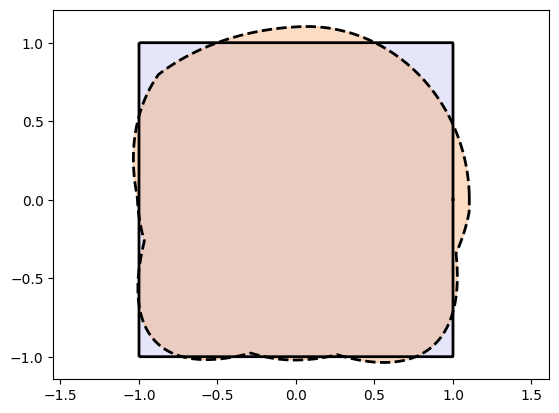

In [2]:
from assets.shapes import square

# Generate target curve points
num_pts = 1000
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)
Xt_square = square(num_pts)

square_net = NIGnet(layer_count = 3, act_fn = nn.PReLU)
automate_training(
    model = square_net, loss_fn = gs.MSELoss(), X_train = t, Y_train = Xt_square,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

Xp_square = square_net(t)
plot_curves(Xp_square, Xt_square)

We observe that the fit is really bad.

This is because the network first transforms the interval $t\in [0, 1]$ to a circle and then deeper
layers try to transform that to a square. This is not an easy task as the network has to transform
the circle arcs to the four straight edges.

Let's have a look at the first transformation as discussed in the section
[](#closed_transformation):
:::{math}
C(t) = 
\begin{bmatrix}
cos(2\pi t)\\
sin(2\pi t)
\end{bmatrix}
:::

The point $[\cos(2\pi t), \sin(2\pi t)]$ is a point on the unit circle centered at the origin. What
is happening here is that the open interval $t \in [0, 1]$ is transformed to a circle that makes
sure that the first and the last point are the same and when fed into the network lead to the same
output point and hence create closed curves. This is explained visually in
[](#closed_condition_linesegment_to_circle).
:::{figure} assets/closed_condition_linesegment_to_circle.svg
:label: closed_condition_linesegment_to_circle
:alt: Transforming the line segment [0, 1] to the unit circle centered at the origin.
:height: 150px
Transforming the line segment $[0, 1]$ to the unit circle centered at the origin.
:::

We could have also achieved the closed condition by transforming to a square instead of a circle.
For the above problem of fitting to a square this should help immensely as the Injective Network has
to learn the identity mapping only! This is easy to do when using the `PReLU` activation.

::::{dropdown} Code for transforming $[0, 1]$ to unit square
:::{literalinclude} assets/shapes.py
:start-at: square
:end-at: return
:::
::::

In [3]:
from assets.shapes import square_from_t

class InjectiveNet_SquareClosed(nn.Module):
    def __init__(self, layer_count, act_fn):
        super().__init__()

        # Transform from t on the [0, 1] interval to unit square for closed shapes
        self.closed_transform = square_from_t

        layers = []
        for i in range(layer_count):
            layers.append(nn.Linear(2, 2))
            layers.append(act_fn())
        
        self.linear_act_stack = nn.Sequential(*layers)
    
    def forward(self, t):
        x = self.closed_transform(t)
        x = self.linear_act_stack(x)
        return x

Epoch: [   1/1000]. Loss:    0.579582
Epoch: [ 200/1000]. Loss:    0.000000
Epoch: [ 400/1000]. Loss:    0.000000
Epoch: [ 600/1000]. Loss:    0.000000
Epoch: [ 800/1000]. Loss:    0.000000
Epoch: [1000/1000]. Loss:    0.000000


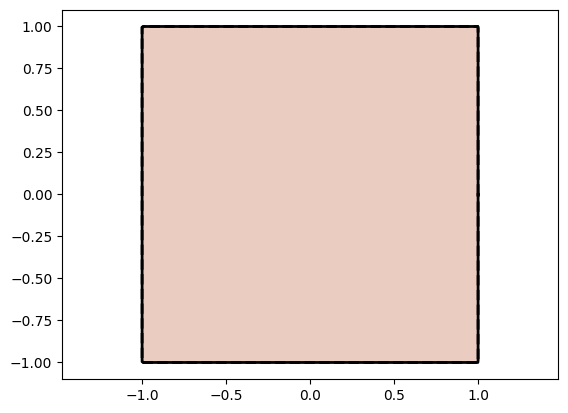

Layer: linear_act_stack.0.weight | Values : tensor([[1.0000e+00, 1.6361e-08],
        [2.4072e-09, 1.0000e+00]], grad_fn=<SliceBackward0>) 

Layer: linear_act_stack.0.bias | Values : tensor([-1.3566e-07, -6.1809e-08], grad_fn=<SliceBackward0>) 

Layer: linear_act_stack.1.weight | Values : tensor([1.0000], grad_fn=<SliceBackward0>) 



In [4]:
# Generate target curve points
num_pts = 1000
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)
X_t_square = square(num_pts)

square_net = InjectiveNet_SquareClosed(layer_count = 1, act_fn = nn.PReLU)
automate_training(
    model = square_net, loss_fn = gs.MSELoss(), X_train = t, Y_train = X_t_square,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

X_p_square = square_net(t)
plot_curves(X_p_square, X_t_square)

# Print model parameters after learning
for name, param in square_net.named_parameters():
    print(f"Layer: {name} | Values : {param[:2]} \n")

Observe above that the network indeed learns the identity mapping as the linear transformation
matrix ends up as the identity matrix and the PReLU activation function ends up as $x$ that is the
identity map with the slope as 1 and bias being 0.